# Lab 7: Survival Modeling

## Overview
This lab focuses on survival modeling techniques and their applications in statistical analysis. The primary topics covered include Cox regression, regularized Cox regression, Random Survival Forest, Kaplan-Meier curve analysis, and multiple testing correction.

## Topics Covered

### 1. Survival Models
Survival models analyze time-to-event data, allowing us to estimate hazard rates and survival probabilities. Below are the key models explored:

| Model                      | Description |
|----------------------------|-------------|
| **Cox Regression**         | A semi-parametric model that estimates the hazard ratio while accounting for covariates. |
| **Regularized Cox Regression** | A variant of Cox regression incorporating LASSO or Ridge penalties to handle high-dimensional data. |
| **Random Survival Forest** | A non-parametric ensemble learning method that uses decision trees to model survival data. |

#### Implementation Notes
- Cox regression: Implemented using `lifelines` or `statsmodels` in Python.
- Regularized Cox regression: Uses L1/L2 penalties with `scikit-survival` or `sksurv`.
- Random Survival Forest: Implemented via `scikit-survival` or `sksurv` with hyperparameter tuning.

### 2. Kaplan-Meier Curve Analysis
The Kaplan-Meier estimator is a non-parametric method for estimating survival probabilities over time.

<img src="km-curve.png" alt="drawing" style="width:600px;"/>

| Feature                | Description |
|------------------------|-------------|
| **Survival Function**  | Estimates the probability of survival beyond a certain time point. |
| **Log-Rank Test**      | Compares survival distributions across groups. |
| **Visualization**      | Stepwise function plotted using `matplotlib` or `lifelines`. |

#### Interpretation
- A steep drop in the Kaplan-Meier curve suggests high event occurrence at that time point.
- Log-rank test helps assess statistical differences between survival curves of different groups.

### 3. Dataset Usage
While we have skeleton code in the notebook using pre-loaded datasets from `lifelines` and `sksurv` packages, we will also explore a publicly available dataset from [NSCLC Radiogenomics](https://www.cancerimagingarchive.net/collection/nsclc-radiogenomics/). This dataset provides imaging and clinical data for non-small cell lung cancer (NSCLC) patients, allowing us to apply survival analysis techniques in a real-world context.


## Summary
- **Cox models** estimate hazard ratios for covariates.
- **Kaplan-Meier curves** visualize survival probabilities over time.
- **Real-world dataset** from NSCLC Radiogenomics allows practical application of survival modeling.

Each section includes hands-on coding exercises and questions for deeper exploration.


## 1. Survival Models

### 1.1 Cox Regression

We will start by implementing Cox regression for survival analysis. We will also explore different parameters and visualize the results.

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -658.75
         time fit was run = 2025-07-03 15:02:19 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
fin       -0.38      0.68      0.19           -0.75           -0.00                0.47                1.00
age       -0.06      0.94      0.02           -0.10           -0.01                0.90                0.99
race       0.31      1.37      0.31           -0.29            0.92                0.75                2.50
wexp      -0.15      0.86      0.21           -0.57            0.27                0.57                1.30
mar       -0.43      0.65      0.38           -1.18            0.31                0.31                1.37
paro      -0.08      0.92      0.20           -0.47            0.30                0.63                1.35
prio       0.09      1.10      0.03            0.04            0.15                1.04                1.16

           cmp to     z      p  -log2(p)
covariate                               
fin          0.00 -1.98   0.05      4.40
age          0.00 -2.61   0.01      6.79
race         0.00  1.02   0.31      1.70
wexp         0.00 -0.71   0.48      1.06
mar          0.00 -1.14   0.26      1.97
paro         0.00 -0.43   0.66      0.59
prio         0.00  3.19 <0.005      9.48
---
Concordance = 0.64
Partial AIC = 1331.50
log-likelihood ratio test = 33.27 on 7 df
-log2(p) of ll-ratio test = 15.37

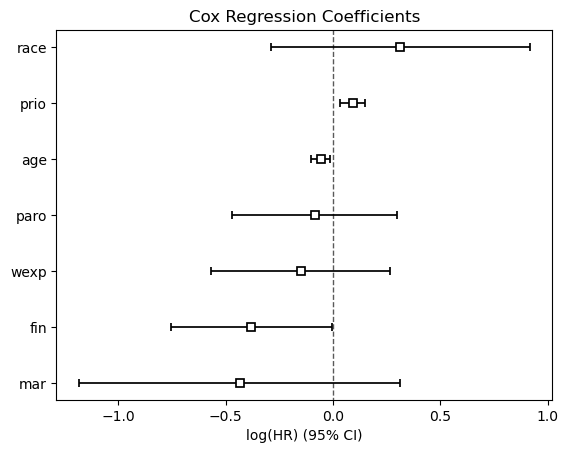

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi

# Load the Rossi dataset
data = load_rossi()

# Fit the Cox proportional hazards model
cph = CoxPHFitter()
cph.fit(data, duration_col='week', event_col='arrest')

# Print the summary of the model
cph.print_summary()

# Plot the coefficients
cph.plot()
plt.title('Cox Regression Coefficients')
plt.show()


In [ ]:
CoxPHFitter?
# load_rossi?

### Questions for Exploration

1. How do we interpret the hazard ratios derived from the Cox model, and what do they imply about risk factors?
2. What assumptions does the Cox proportional hazards model make, and how can we test if they hold? HINT: check this [link](https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html).
3. What happens to the model performance if you include or exclude certain covariates?
4. What happens to the model performance if you change the `baseline_estimation_method`?

### 1.2 Lasso for Censored Data

Now, we will implement Lasso for censored data using the Cox regression model with L1 regularization. We will also explore different parameters and visualize the results.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sksurv.linear_model import CoxnetSurvivalAnalysis
from lifelines.datasets import load_rossi
from sklearn.model_selection import train_test_split
from sksurv.metrics import concordance_index_censored

# Load the Rossi dataset
data = load_rossi()

# Prepare the data for sksurv
X = data.drop(columns=['week', 'arrest']).astype(float)
y = np.array([(bool(event), time) for event, time in zip(data['arrest'], data['week'])], dtype=[('event', bool), ('time', float)])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the Cox proportional hazards model with L1 regularization
cph_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0)
cph_lasso.fit(X_train, y_train)

# Predict the risk scores on the test set
risk_scores = cph_lasso.predict(X_test)

# Calculate the concordance index
c_index = concordance_index_censored(y_test['event'], y_test['time'], risk_scores)[0]
print(f'Concordance Index: {c_index:.4f}')


### Questions for Exploration

1. How does the L1 regularization affect the coefficients of the Cox regression model? HINT: examine `cph_lasso.coef_`.
2. How does penalizing the Cox model (e.g., L1/L2 regularization) impact variable selection and model performance?
3. What happens to the model performance if you change the `l1_ratio`?
4. What are the differences in model performance and interpretability between `CoxPHFitter` from `lifelines` and `CoxnetSurvivalAnalysis` from `sksurv`?

### 1.3 Random Survival Forest

Next, we will implement a Random Survival Forest for survival analysis. We will also explore different parameters and visualize the results.

In [ ]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.datasets import load_whas500
from sksurv.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance

# Load the WHAS500 dataset
data_x, data_y = load_whas500()

# Encode categorical variables
encoder = OneHotEncoder()
data_x = encoder.fit_transform(data_x)

# Train a Random Survival Forest model
rsf = RandomSurvivalForest(n_estimators=100, random_state=42)
rsf.fit(data_x, data_y)

# please refer to https://scikit-survival.readthedocs.io/en/stable/user_guide/random-survival-forest.html
result = permutation_importance(rsf, data_x, data_y, n_repeats=15, random_state=42)
feature_importance = pd.DataFrame(
         {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=data_x.columns,
).sort_values(by="importances_mean", ascending=False)

# Sort by importances_mean and plot
feature_importance = feature_importance.sort_values(by="importances_mean", ascending=False)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(feature_importance.index, feature_importance['importances_mean'], xerr=feature_importance['importances_std'], align='center')
plt.xlabel('Mean Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
RandomSurvivalForest?
# load_whas500?
# permutation_importance?

### Questions for Exploration

1. How do the feature importances from the Random Survival Forest model interpret the relationship between covariates and survival time?
2. What happens to the model performance if you change the number of trees (`n_estimators`)?
3. How does the choice of dataset affect the Random Survival Forest results and their interpretation?

## 2. Kaplan-Meier Curve Analysis

We will perform Kaplan-Meier curve analysis to visualize and interpret survival probabilities over time. We will also explore different visualization techniques.

In [ ]:
from lifelines import KaplanMeierFitter

# Load the Rossi dataset
data = load_rossi()

# Fit the Kaplan-Meier estimator
kmf = KaplanMeierFitter()
kmf.fit(data['week'], event_observed=data['arrest'])

# Plot the Kaplan-Meier curve
kmf.plot_survival_function()
plt.title('Kaplan-Meier Curve')
plt.xlabel('Time (weeks)')
plt.ylabel('Survival Probability')
plt.show()


### Questions for Exploration

1. What happens to the Kaplan-Meier curves if you stratify the data by different covariates?
2. How can you extract median survival time from a Kaplan-Meier estimator in `lifelines`?
3. How do confidence intervals impact the interpretation of Kaplan-Meier curves?
4. How can you compare multiple survival groups using statistical tests such as the log-rank test? HINT: check this [link](https://lifelines.readthedocs.io/en/latest/lifelines.statistics.html).

In [ ]:
KaplanMeierFitter?

## 3. Dataset Usage

On Blackboard, you'll find a folder titled 'NSCLC Dataset'. In here, you'll find two spreadsheets:
- `tpm_counts.csv` which contains RNA sequencing data in transcripts per million (TPM);
- `clinical.csv` which contains the associated clinical data for the study.

In [ ]:
rna = pd.read_csv('NSCLC Dataset/tpm_counts.csv')

# describe the data
rna.head()
# rna.describe()   # <-- will show the summary statistics of the data, but not recommended as it will take awhile


In [ ]:
clinical = pd.read_csv('NSCLC Dataset/clinical.csv')

# describe the data
clinical.head()
# clinical.describe()

Next, try incorporating clinical data from `clinical.csv` into the analysis. To do this, follow these steps:
1. Create a `time` column by calculating the number of days between **'Date of Last Known Alive'** and **'CT Date'** (both in MM/DD/YYYY format).
2. Convert the **'Survival Status'** column into a boolean event indicator, where **Death** corresponds to `True` (event observed).

In [10]:
import pandas as pd
from datetime import datetime
import numpy as np
from sksurv.util import Surv

clinical_data = clinical.copy()

# Convert date columns to datetime format
clinical_data["Date of Last Known Alive"] = pd.to_datetime(clinical_data["Date of Last Known Alive"], format="%m/%d/%Y")
clinical_data["CT Date"] = pd.to_datetime(clinical_data["CT Date"], format="%m/%d/%Y")

# Calculate time in days
clinical_data["time"] = (clinical_data["Date of Last Known Alive"] - clinical_data["CT Date"]).dt.days - clinical_data['Days between CT and surgery']

# Convert event column to boolean (Death = True, Alive = False)
clinical_data["event"] = clinical_data["Survival Status"].apply(lambda x: True if x == "Death" else False)

# Convert to sksurv structured array format
survival_data = Surv.from_dataframe("event", "time", clinical_data)

## Extensions

Explore other survival analysis techniques such as:
- Accelerated Failure Time (AFT) models
- Competing risks models
- Time-dependent covariates in Cox regression

Compare their performance and interpretation with the techniques covered in this lab.